# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [74]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


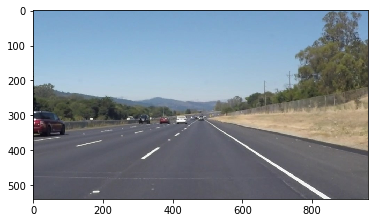

In [58]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [114]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [662]:
import os
os.listdir("test_images/")

['YellowWhite.jpg',
 'solidYellowLeft.jpg',
 'YellowUnderShade.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'allGray.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'YellowUnderShade2.jpg',
 'YellowWhite2.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

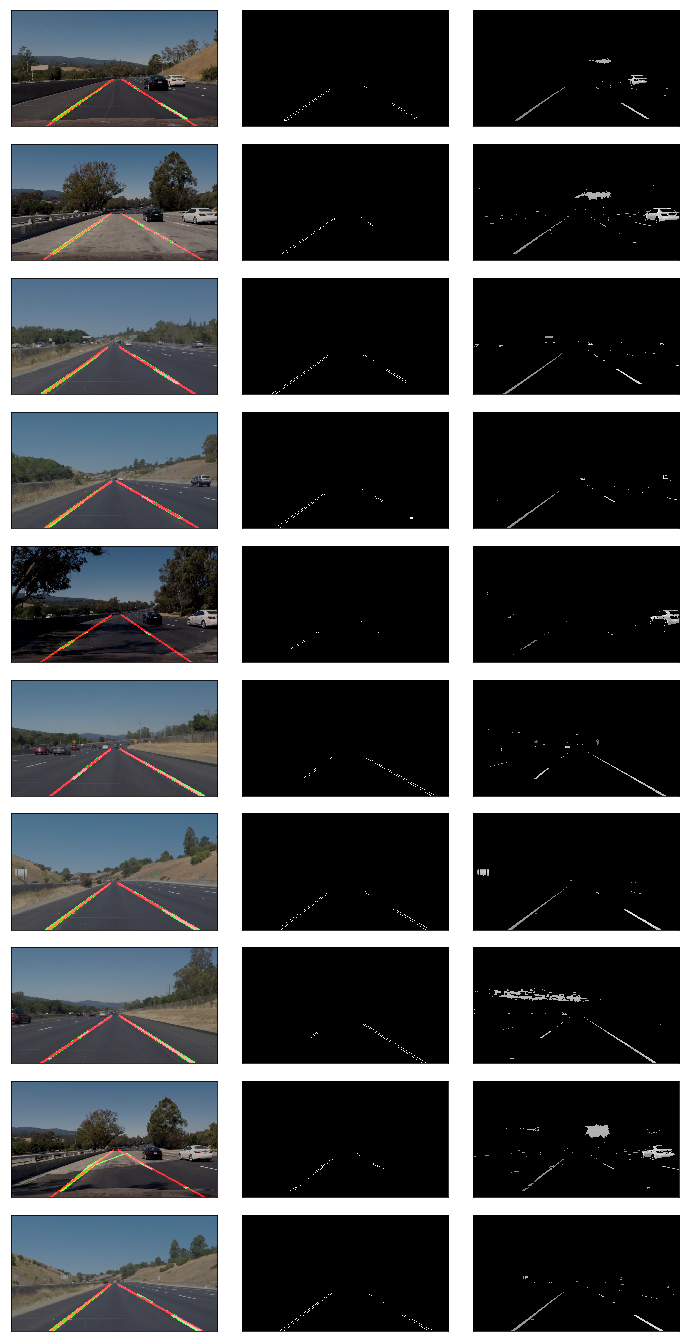

In [165]:
def calculate_mask_colors_hsv():
    """Calculate colors in HSV used for defining a color mask
    """
    # Show the three components of the color yellow in the HSV color space
    # To turn this color into a range for masking, +/- 10 to the Hue value
    # for the Hue range and set a range 100-255 for the Value and 
    # Saturation values
    yellow = np.uint8([[[255,255,0 ]]])
    hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2HSV)
    print (hsv_yellow)

    # Show the three components of the color white in the HSV color space
    # The normal approach to turn a color into a range doesn't work here since
    # white isn't really a color. Looking at an HSV color cylinder we can see
    # that the Hue and Saturation don't really matter as any high Value value 
    # is essentially white. We can see this with the result of the code below
    # [0, 0, 255] (No Hue, No Saturation, 100% light). To turn this into a range
    # use 0-255 for the Hue, 0-255 for Saturation and 200-255 for the Value,
    # increasing the lower Value to increase the sensitivity
    white = np.uint8([[[255,255,255 ]]])
    hsv_white = cv2.cvtColor(white,cv2.COLOR_RGB2HSV)
    print (hsv_white)
    
def calculate_mask_colors_hls():
    """Calculate colors in HLS used for defining a color mask
    """
    # Show the three components of the color yellow in the HLS color space
    # To turn this color into a range for masking, +/- 10 to the Hue value
    # for the Hue range and set a range 100-255 for the Lightness and 
    # Saturation values
    yellow = np.uint8([[[255,255,0 ]]])
    hls_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2HLS)
    print (hls_yellow)

    # Show the three components of the color white in the HLS color space
    # The normal approach to turn a color into a range doesn't work here since
    # white isn't really a color. Looking at an HLS color cylinder we can see
    # that the Hue and Saturation don't really matter as any high Light value 
    # is essentially white. We can see this with the result of the code below
    # [0, 255, 0] (No Hue, 100% Light, No Saturation). To turn this into a range
    # use 0-255 for the Hue, 200-255 for the Light and 0-255 for the Saturation,
    # increasing the lower Light value to increase the sensitivity
    white = np.uint8([[[255,255,255 ]]])
    hls_white = cv2.cvtColor(white,cv2.COLOR_RGB2HLS)
    print (hls_white)
    
def mask_colors_rgb(img):
    """Given an image in RGB space, mask the white and yellow color ranges for 
    lane isolation
    """
    
    # white mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower, upper)
    
    # yellow mask (Hard to determine a good linear mask for all yellow, I determined
    # these values by looking at a range of different types of yellow and their respective
    # RGB values)
    lower = np.uint8([ 180, 180, 0])
    upper = np.uint8([ 255, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    
    # combined mask
    combined = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = combined)

def mask_colors_hsv(img):
    """Given an image in HSV space, mask the white and yellow color ranges for 
    lane isolation
    """
    
    # See calculate_mask_colors_hsv() above for deriving ranges in HSV color space
    # white mask
    lower = np.uint8([0, 0, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower, upper)
    
    # yellow mask
    lower = np.uint8([ 20, 100, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    
    # combined mask
    combined = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = combined)

def mask_colors_hls(img):
    """Given an image in HLS space, mask the white and yellow color ranges for 
    lane isolation
    """
    
    # See calculate_mask_colors_hls() above for deriving ranges in HLS color space
    # white mask
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower, upper)
    
    # yellow mask
    lower = np.uint8([ 20, 100, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    
    # combined mask
    combined = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = combined)

def process_image_plot(item, ax, mplot):
    """plot an image using the given axis and plot reference
    
    Args:
        item -- item holding image data to be ploted
        ax -- axis reference that can be used to modify the plot
        mplot -- reference to matplotlib that can be used to plot the image
    """    
    ax.set_xticks([]) # remove horizontal ticks from image
    ax.set_yticks([]) # remove vertical ticks from image
    mplot.imshow(item[0], cmap=item[1]) # display image with specified cmap

def tile_images(images, col_num):
    """Plot multiple images in a single image
    
    Args:
        images -- array of images to plot
        col_num -- number of required columns in the plot
    """
    # determine image size to calculate desired figure height
    shape = images[0][0].shape
    img_height = float(shape[0])
    img_width = float(shape[1])
    tile_plots(images, col_num, img_width, img_height, process_image_plot)

def tile_plots(items, col_num, item_width, item_height, processor):
    """Plot multiple items in a single image, each item is processed using the 
    given processor function. The processor function takes as arguments 
    an item, axis and plot reference. It's up to the processor to define how to
    use the axis and plot object to plot the item.
    
    Args:
        items -- array of objects to be processed and ploted in each cell of the figure
        col_num -- number of required columns in the plot
        item_width -- original width of the item, used to retain aspect ratio
        item_height -- original width of the item, used to retain aspect ratio
        processor -- function which takes an item, axis and plot reference and uses
            the axis and plot reference to plot the item
    """
    if len(items) == 0:
        return
    notebook_pixel_width = 720.0
    col_width = notebook_pixel_width / float(col_num)
    row_height = (col_width / item_width) * item_height
    # divide images by required columns to determine number of rows
    row_num = math.ceil(len(items)/col_num)
    fig = plt.figure()
    # figure size is specified in inches, so divide required pixel size by dots per inch
    dpi = fig.get_dpi()
    fig.set_size_inches(notebook_pixel_width/float(dpi), (row_num*row_height)/float(dpi))
    # create a grid layout to position the individual plots
    gridspec.GridSpec(row_num ,col_num)
    for i, item in enumerate(items):
        row = i // col_num # integer floor divide to increment row after all columns
        col = i % col_num # increment col from 0 to cols-1 and cycle back to 0
        ax = plt.subplot2grid((row_num, col_num), (row, col)) # create plot in correct grid cell
        processor(item, ax, plt)
        plt.tight_layout() # remove margins from figure
        
    plt.show()


def is_previous_lines_set(previous_lines):
    """Does the previous_lines array hold valid data
    
    Args:
        previous_lines -- 
        
    Returns:
        True if valid data is in the previous_lines array
    """
    if previous_lines is not None and previous_lines[0][2] != 0 and previous_lines[0][3] != 0:
        return True
    return False

def get_line_difference(oldLine, newLine):
    """Calculate approximate difference between two lines, used for comparing 
    previous lane lines to current ones
    
    Args:
        oldLine -- 
        newLine --
        
    Returns:
        A numerical value that increases as the difference between the provided 
        lines increases
    """
    diff = abs(oldLine - newLine)
    percentDiff = diff / oldLine # Percent by element.
    meanPctDiff = np.mean(percentDiff)
    return meanPctDiff

def average_lines(hough_lines, old_lines, horizon_x):
    
    previous_weight_influence = 20.0 # This should be a value > 5.0
    min_gradient = 0.5
    
    left_grads = []
    left_intercepts = []
    left_weights  = []
    
    right_grads = []
    right_intercepts = []
    right_weights = []
    
    old_left_grad = None
    old_right_grad = None
    if is_previous_lines_set(old_lines):
        old_grads = (old_lines[:, 3] - old_lines[:, 1]) / (old_lines[:, 2] - old_lines[:, 0]) 
        old_left_grad = old_grads[0]
        old_right_grad = old_grads[1]
    
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            # avoid verticle lines (and zero divides)
            if (x2 - x1) == 0:
                break
            # calculate the gradient and skip any with an absolute value less than 0.5
            # as it is too horizontal and unlikely to be a lane
            grad = (y2 - y1) / (x2 - x1)
            if abs(grad) < min_gradient:
                break
            intercept = y1 - grad*x1
            length = (y2 - y1)**2 + (x2 - x1)**2 # relative length
            # negative gradient is the line on the left side (since the y axis is inverted)
            if grad < 0:
                # left lines should end on the left of the horizon
                if x2 < horizon_x:
                    grad_weight = min((previous_weight_influence - \
                                       abs(grad - old_left_grad))**2,1) if old_left_grad != None else 1.0
                    # multiply the length by a value that increases quadratically when the 
                    # current and previous line are similiar
                    weight = length * grad_weight
                    left_weights.append(length)
                    left_grads.append(grad)
                    left_intercepts.append(intercept)
            else:
                # right lines should end on the right of the horizon
                if x2 > horizon_x:
                    grad_weight = min((previous_weight_influence - \
                                       abs(grad - old_right_grad))**2,1) if old_right_grad != None else 1.0
                    # multiply the length by a value that increases quadratically when the 
                    # current and previous line are similiar
                    weight = length * grad_weight
                    right_weights.append(length)
                    right_grads.append(grad)
                    right_intercepts.append(intercept)
    
#     plt.hist(left_grads, weights=left_weights)
    
    # Calculate the average weighted left line
    if len(left_weights) > 0:
        left_grad = np.dot(left_grads, left_weights) / np.sum(left_weights)
        left_intercept = np.dot(left_intercepts, left_weights) / np.sum(left_weights)
    else:
        left_grad = None
        left_intercept = None
        
    # Calculate the average weighted right line
    if len(right_weights) > 0:
        right_grad = np.dot(right_grads, right_weights) / np.sum(right_weights)
        right_intercept = np.dot(right_intercepts, right_weights) / np.sum(right_weights)
    else:
        right_grad = None
        right_intercept = None
        
    return left_grad, left_intercept, right_grad, right_intercept

def extrapolate_line(grad, intercept, horizon_y, y_max):
    
    line = None
    if grad is not None:
        line = np.array([0,0,0,0])
        line[0] = (y_max - intercept) / grad
        line[1] = y_max
        line[2] = (horizon_y - intercept) / grad
        line[3] = horizon_y
        
    return line

def check_and_average_variation(lane_lines, previous_lines):
    possibleError = False
    history_stickyness = 1.3 # values > 1 or < 2, determines averaging with previous line
    history_variation_tolerance = 0.3 # if the difference between old and new lines is greater, assume an error
    
    # If this algorithm is processing video, check the lane lines from the last frame. 
    # If there's too much difference highlight that an error may have occured.
    # If the lines are similar, average the old line and new line to smoothly transition
    # between the two
    # You could also default to the previous line if the difference is too large as a hack to avoid
    # returning a ridiculous line. This is probably dangerous if done for several consecutive frames
    if is_previous_lines_set(previous_lines):
        if lane_lines[0] is not None and lane_lines[1] is not None:
            for i in range(2):
                # If the difference between the old line and the new line is acceptable
                diff = get_line_difference(previous_lines[i], lane_lines[i])
                if diff < history_variation_tolerance:
                    lane_lines[i] = lane_lines[i] + (previous_lines[i] - lane_lines[i]) / history_stickyness
                else:
                    print('lane lines variation from previous line exceeded tolerance: {0}'.format(diff))
                    print (lane_lines[i])
                    print (previous_lines[i])
                    possibleError = True
                    # lane_lines = previous_lines
        else:
            print('Unable to find two lane lines')
            print(left_lines)
            print(right_lines)
            possibleError = True
            # lane_lines = previous_lines
            
    return lane_lines, possibleError
        
def find_lanes(image, previous_lines=None):
    """Given an image from the dashboard of a car, determine the lane lines on 
    the road in front of it
    
    Args:
        image -- image from the car dashboard
        previous_lines -- if the image is from a video frame, optionally 
            provide the lines determined from the previous frame
    
    Returns:
        Numpy array of vectors, each vector holds four values representing the 
        points that define the line; x1, y1, x2, y2   
    """
    # convert the image to the HLS color model so that the yellow color
    # can be defined invarient of shadows etc, for use in a color mask
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Alternate color space for evaluating HSV for masking colors
    # hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # mask the image to highlight yellow and white features
    masked = mask_colors_hls(hls)

    # Alternate masking for HSV color space
    # masked = mask_colors_hsv(hsv)
    
    # Alternate masking for RGB color space
    # masked = mask_colors_rgb(image)
    
    # Alternative to masking, try using a single channel from HLS color space
    # (h, l, s) = cv2.split(hls)
    # hue_only = cv2.merge((h, h, h))
    # light_only = cv2.merge((l, l, l))
    # sat_only = cv2.merge((s, s, s))
    
    # convert the masked image to grayscale for edge detection to work accurately
    gray_img = grayscale(masked)

    # blur the image to reduce noise and avoid detecting irrelevant lines
    blur_k_size = 13
    blur = gaussian_blur(gray_img, blur_k_size)

    # Define our parameters for Canny and apply. 1:3 to 1:2 ratio is advised
    low_threshold = 50 # gradients below this are ignored, gradients above are considered as edges
    high_threshold = 150 # gradients above this are assumed to be edges
    edges = canny(blur, low_threshold, high_threshold)

    # draw a mask from the bottom edges of the image to the horizon with a blunted point defined by cutoff
    imshape = image.shape
    cutoff = 90 # Slice this height of the triangle to the horizon to create a trapazoid
    horizon_x = imshape[1]/2
    horizon_y = imshape[0]/2
    bl = (0,imshape[0]) #bottom left
    tl = (horizon_x-cutoff, horizon_y+cutoff) #top left
    tr = (horizon_x+cutoff, horizon_y+cutoff) #top right
    br = (imshape[1],imshape[0]) #bottom right
    vertices = np.array([[bl, tl, tr, br]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20  # minimum number of pixels making up a line
    max_line_gap = 200 # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    hough_lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_len, max_line_gap)
        
    possibleError = False
    if hough_lines is None or len(hough_lines) == 0:
        print ("Error, no lines found in image / frame")
        possibleError = True
        lane_lines = np.array([])
        hough_lines = np.array([])
    else:
        # determine average lane lines based on the hough lines found and the previous lane lines
        left_grad, left_intercept, right_grad, right_intercept = average_lines(hough_lines, previous_lines, horizon_x)
        
        # Extrapolate the lines to cover the full distance by solving y = mx + b for the 
        # required y intercepts at the bottom of the image and at the horizon
        horizon_y = (imshape[0]/5)*3  
        y_max = bl[1]
        left_line = extrapolate_line(left_grad, left_intercept, horizon_y, y_max)
        right_line = extrapolate_line(right_grad, right_intercept, horizon_y, y_max)
        lane_lines = np.array([left_line, right_line])

        # check how much the lines varied from the previous lines, if specified. Also alter 
        # the new lines to move towards the average of the new and the old to smooth the line
        # forecast
        lane_lines, error = check_and_average_variation(lane_lines, previous_lines)
    
    possibleError = possibleError & error
    return lane_lines, possibleError, hough_lines, masked_edges, gray_img




import os
images = os.listdir("test_images/")
processed_images = []
# for each of the test images
for image_path in images:
    
    # read the image and determine the road lanes (along with other values useful for visual debugging)
    img = mpimg.imread(os.path.join('test_images/', image_path))
    lane_lines, possibleError, lines, masked_edges, gray_img = find_lanes(img)

    # Iterate over the lines found in the image for visual debugging
    overlay = np.zeros_like(img)
    for line in lines:
        if line is not None:
            for x1,y1,x2,y2 in line:
                cv2.line(overlay,(x1,y1),(x2,y2),(0,255,0),6)
            
    # Iterate over the calculate lane lines
    for line in lane_lines:
        if line is not None:
            for x1,y1,x2,y2 in [line]:
                cv2.line(overlay,(x1,y1),(x2,y2),(255,0,0),10)

    # Overlay the lines over the original image with some transparency
    opacity = 0.7
    img = weighted_img(overlay, img, α=opacity)

    # Add the original image with lines overlayed, masked Canny edge detection image and color masked image
    # for this test image
    processed_images.append((img, None))
    processed_images.append((masked_edges, 'gray'))
    processed_images.append((gray_img, 'gray'))

# Display all the collected image in a regular grid, specifying the number of columns
tile_images(processed_images, 3)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image, previous_lines, use_history, debug):
    lane_lines, possibleError, lines, masked_edges, gray_img  = find_lanes(image, previous_lines)
    
    lane_color = (255,0,0)
    candidate_color = (0,255,0)
    
    # if the new lane line is potentially wrong, don't update the previous line to avoid
    # penalising a future correct line due to a previously incorrect ground truth
    if use_history and not possibleError:
        previous_lines[0] = lane_lines[0]
        previous_lines[1] = lane_lines[1]
         
    # Draw candidate lines for debugging
    overlay = np.zeros_like(image)
    if debug:
        for line in lines:
            if line is not None:
                for x1,y1,x2,y2 in line:
                    cv2.line(overlay,(x1,y1),(x2,y2),candidate_color,5)
            
    # Iterate over the lane lines and draw on the original image
    for line in lane_lines:
        if line is not None:
            for x1,y1,x2,y2 in [line]:
                cv2.line(overlay,(x1,y1),(x2,y2),lane_color,10)
    
    opacity = 0.7
    final = weighted_img(overlay, image, α=opacity)
    
    # if an error occured take a snapshot of the before and after image for this frame
    if possibleError and debug:
        cv2.imwrite('error_images/image.png',image)
        cv2.imwrite('error_images/final.png',final)
    
    return final

# Using some scope trickery to pass an extra few parameters to the frame processor
def process_image_wrapper(clip, previous_lines, use_history=True, debug=False):
    def process_image_stateful(image):
        return process_image(image, previous_lines, use_history, debug)
    
    return clip.fl_image(process_image_stateful)


Let's try the one with the solid white lane on the right first ...

In [157]:
previous_lines = np.array([[0,0,0,0],
 [0,0,0,0]])

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fx(process_image_wrapper, previous_lines, True, False) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 48.4 s, sys: 460 ms, total: 48.9 s
Wall time: 8.24 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [158]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [159]:
previous_lines = np.array([[0,0,0,0],
 [0,0,0,0]])

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fx(process_image_wrapper, previous_lines, True, False) 
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:26<00:00, 26.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 49s, sys: 1.68 s, total: 2min 51s
Wall time: 27.3 s


In [160]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [155]:
previous_lines = np.array([[0,0,0,0],
 [0,0,0,0]])

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fx(process_image_wrapper, previous_lines, True, False) 
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:16<00:00, 14.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 42s, sys: 1 s, total: 1min 43s
Wall time: 17.5 s


In [156]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))